In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


In [ ]:
import torch
import random

digit_colors = {
    0: torch.tensor([1.0, 0.2, 0.2]),
    1: torch.tensor([0.2, 1.0, 0.2]),
    2: torch.tensor([0.2, 0.2, 1.0]),
    3: torch.tensor([1.0, 1.0, 0.2]),
    4: torch.tensor([1.0, 0.2, 1.0]),
    5: torch.tensor([0.2, 1.0, 1.0]),
    6: torch.tensor([1.0, 0.5, 0.2]),
    7: torch.tensor([0.6, 0.2, 1.0]),
    8: torch.tensor([0.2, 0.7, 0.7]),
    9: torch.tensor([1.0, 0.4, 0.7]),
}

class BiasedTexturedMNIST:
    def __init__(self, bias_prob=0.95):
        self.bias_prob = bias_prob

    def __call__(self, img, label,rng):
        img = img.squeeze(0)  # [28,28] grayscale
        img = img.clamp(0,1)

        # Digit mask
        digit_mask = img > 0.2
        bg_mask = ~digit_mask

        # Choose dominant or random color
        if torch.rand(1, generator=rng).item() < self.bias_prob:
            base_color = digit_colors[label]
        else:
            base_color = torch.rand(3, generator=rng)

        base_color = base_color.view(3,1,1)

        # ---------- FOREGROUND (digit stroke) ----------
        grayscale = img.unsqueeze(0)                 # keep MNIST intensity
        fg_color = base_color * grayscale            # color tied to shape
        fg_texture = torch.randn(3,28,28,generator=rng) * 0.08     # subtle texture
        foreground = fg_color + fg_texture

        # ---------- BACKGROUND ----------
        bg_texture = torch.randn(3,28,28,generator=rng) * 0.05     # very subtle noise
        background = base_color * 0.15 + bg_texture  # faint same hue

        # ---------- COMBINE ----------
        rgb = torch.zeros(3,28,28)
        rgb[:, digit_mask] = foreground[:, digit_mask]
        rgb[:, bg_mask] = background[:, bg_mask]

        return rgb.clamp(0,1)


In [ ]:
from torch.utils.data import Dataset

class ColoredMNIST(Dataset):
    def __init__(self, mnist_dataset, bias_prob):
        self.mnist = mnist_dataset
        self.colorizer = BiasedTexturedMNIST(bias_prob=bias_prob)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        rng = torch.Generator()
        rng.manual_seed(idx)
        img, label = self.mnist[idx]
        img = self.colorizer(img, label,rng)
        return img, label


In [ ]:
from torchvision import datasets, transforms

base_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
base_test  = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_easy = ColoredMNIST(base_train, bias_prob=0.95)  # strongly biased
test_hard  = ColoredMNIST(base_test,  bias_prob=0.00)  # mostly wrong colors


In [ ]:
import matplotlib.pyplot as plt
import torch
import random

def show_100_by_digit(dataset, cols=10):
    """
    Displays 100 images from the dataset: 10 for each digit (0–9).
    Works for both grayscale [1,H,W] and RGB [3,H,W].
    """
    digit_to_images = {d: [] for d in range(10)}

    # Collect 10 images per digit
    for img, label in dataset:
        if len(digit_to_images[label]) < 10:
            digit_to_images[label].append(img)
        if all(len(imgs) == 10 for imgs in digit_to_images.values()):
            break

    all_images = [img for digit in range(10) for img in digit_to_images[digit]]

    fig, axes = plt.subplots(10, cols, figsize=(cols, 10))
    for i, ax in enumerate(axes.flatten()):
        img = all_images[i]
        if img.shape[0] == 1:
            ax.imshow(img.squeeze(), cmap="gray")
        else:
            ax.imshow(img.permute(1, 2, 0))
        ax.axis("off")

    plt.suptitle("10 Samples of Each Digit (0–9)", fontsize=16)
    plt.tight_layout()
    plt.show()


the easy train dataset(95% colour to digit correlation) samples:


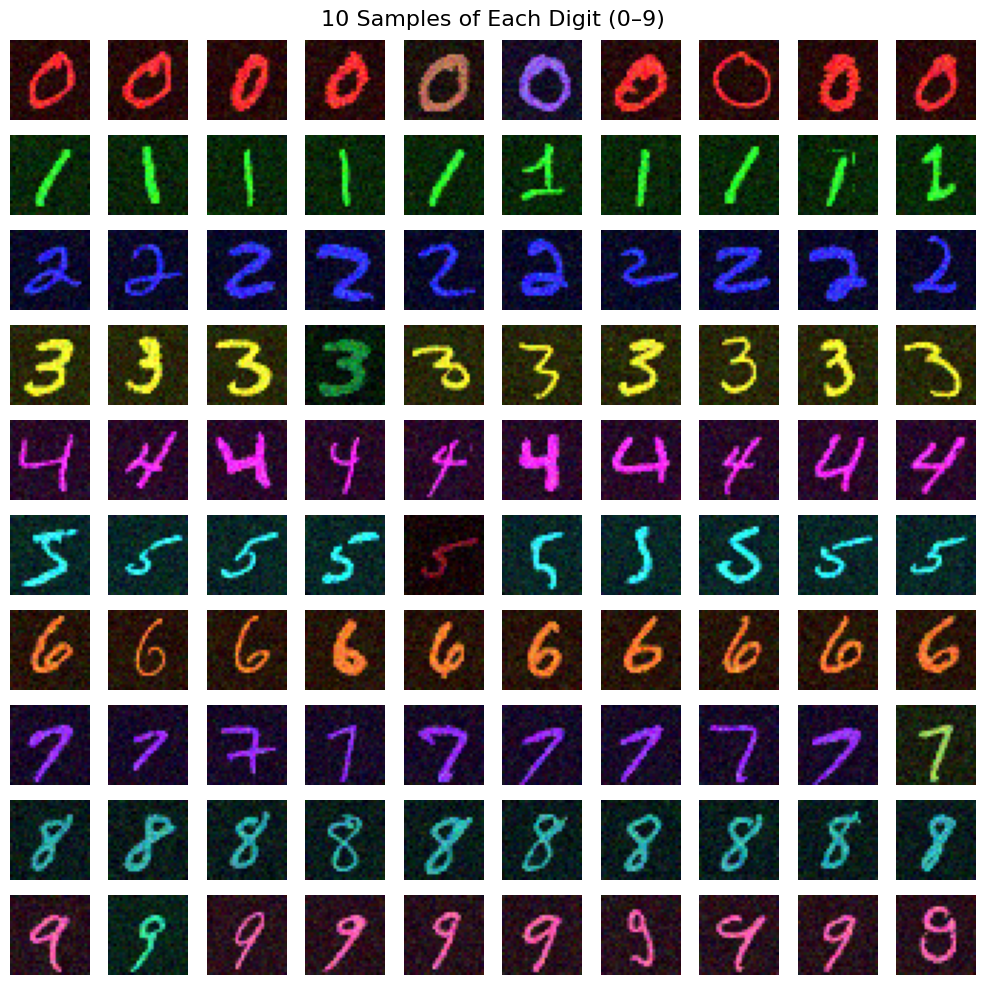

In [ ]:
show_100_by_digit(train_easy)

the hard test dataset(randomized colour relation) samples:


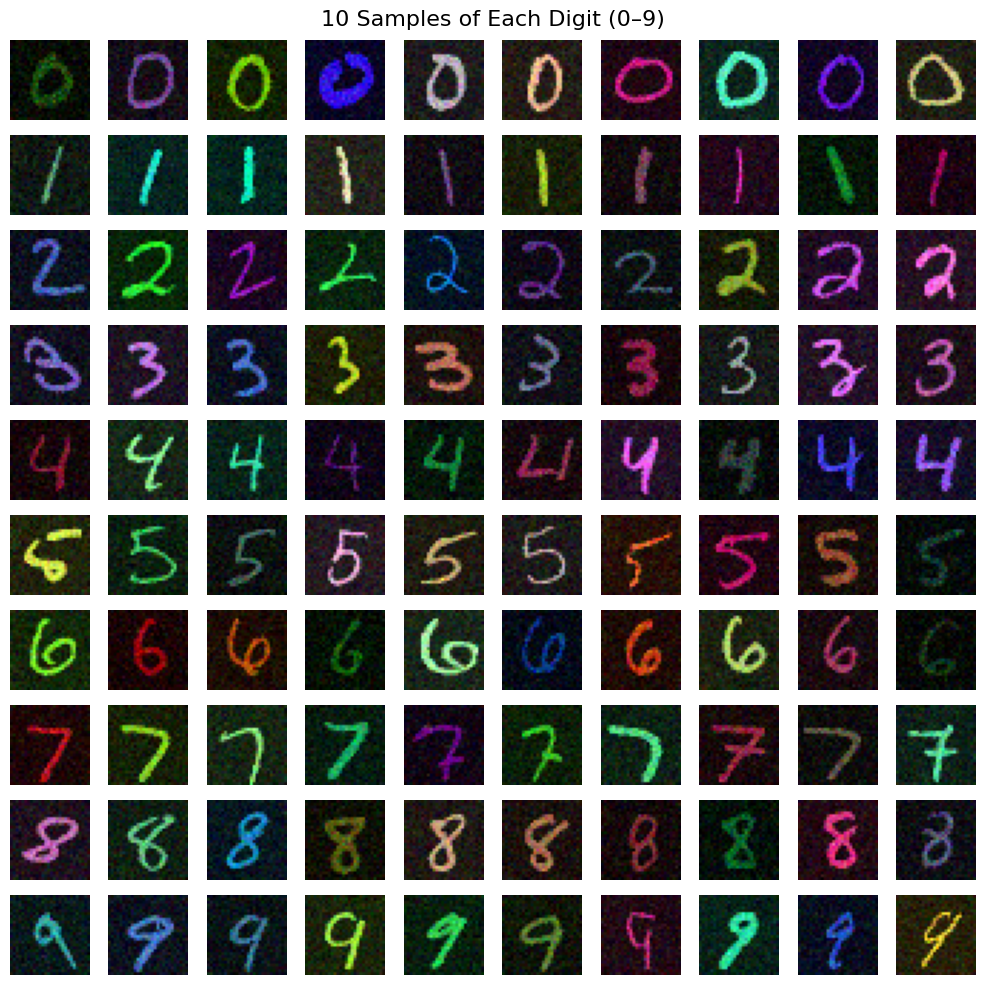

In [ ]:
show_100_by_digit(test_hard)